In [1]:
import os
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
from db.models import DB_FILE, TableName
from db.db import init_db, read_table
from etl.load.loader import load_raw_data, load_clean_data
from pathlib import Path
from etl.transform.transformer import transform_table
from etl.transform.cleaning import (
    drop_rows_missing_emails,
    drop_emails_with_unmatched_nonalpha,
)
from IPython.display import display, HTML
from scipy.stats import entropy
from db.migrations import run_all_migrations

In [2]:
# Ensure paths for exports exist
os.makedirs("export/stats", exist_ok=True)
os.makedirs("export/plots", exist_ok=True)

# Initial EDA on raw data
Before we do any cleaning we will do a quick sanity check and exploration of the raw data as it is given. We'll start by loading the data into the database.

In [3]:
# Delete file to start fresh
path = Path(DB_FILE)
if path.exists():
    os.remove(DB_FILE)

In [4]:
# Initialise SQL database
init_db()

# Load the raw data into our SQL database. If it does not
# raise an exception then it should be successful
load_raw_data(TableName.LP)

Tables created successfully.
Read from LP Contact Data
0 upserted, 155963 inserted into LP
Write to lp_raw table complete!
Written 155963 records to LP


Now we can load the data back into a DataFrame and do some quick checks.

In [5]:
# Load into data frames
lp_df = read_table(TableName.LP)
# Print first 5 rows
lp_df.head()

Read LP table from database!


,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
0,155963,Noah Rawlings,Family Office - Single,None,1833,None,Board of Directors,President,GEN,None,...,WY,US,82001,None,North America,2020 Carey Avenue Suite 314,https://www.1833enterprises.com/,None,LP Contact Data,2025-06-20 13:52:05.717771
1,155962,Stephen Smith,Wealth Manager,Mr.,Smith Financial Corporation,None,"Board of Directors,Investment Team",Founder and Chief Executive Officer,GEN,None,...,None,Canada,None,www.linkedin.com/in/stephen-smith-aa71a71b6/,North America,,https://www.smithfc.ca/,info@smithfc.ca,LP Contact Data,2025-06-20 13:52:05.717771
2,155961,Joonas Huttunen,Investment Company,Mr.,Rake Development Company Oy,None,Investment Team,Chief Investment Officer,"PE,RE",None,...,None,Finland,00120,www.linkedin.com/in/joonas-huttunen/,Europe,"Bulevardi 6 B, 3krs.",https://rake.fi/en/etusivu,None,LP Contact Data,2025-06-20 13:52:05.717771
3,155960,Sijia Wang,Family Office - Multi,Mr.,Oshen,None,None,Managing Partner,"PE,INF",None,...,None,Luxembourg,1471,www.linkedin.com/in/peter-sijia-wang/,Europe,"270, route d'Esch",https://oshenbio.com/,info@oshenbio.com,LP Contact Data,2025-06-20 13:52:05.717771
4,155959,Didier Cowling,Family Office - Multi,Mr.,Oshen,None,None,Managing Partner,"PE,INF",None,...,None,Luxembourg,1471,www.linkedin.com/in/lifesciencesexpert/,Europe,"270, route d'Esch",https://oshenbio.com/,info@oshenbio.com,LP Contact Data,2025-06-20 13:52:05.717771


Lets take a look at the shape and data types.

In [6]:
lp_df.shape, lp_df.dtypes

((155963, 22),
 id                           int64
 investor                    object
 firm_type                   object
 title                       object
 firm                        object
 alternative_name            object
 role                        object
 job_title                   object
 asset_class                 object
 email                       object
 tel                         object
 city                        object
 state                       object
 country                     object
 zip_code                    object
 linkedin                    object
 region                      object
 address                     object
 website                     object
 general_email               object
 source_file                 object
 time_stamp          datetime64[ns]
 dtype: object)

Looks good. Lets inspect missing values. We'll do this by calculating the percentage of missing values for each column and plot the percentages as a bar graph.

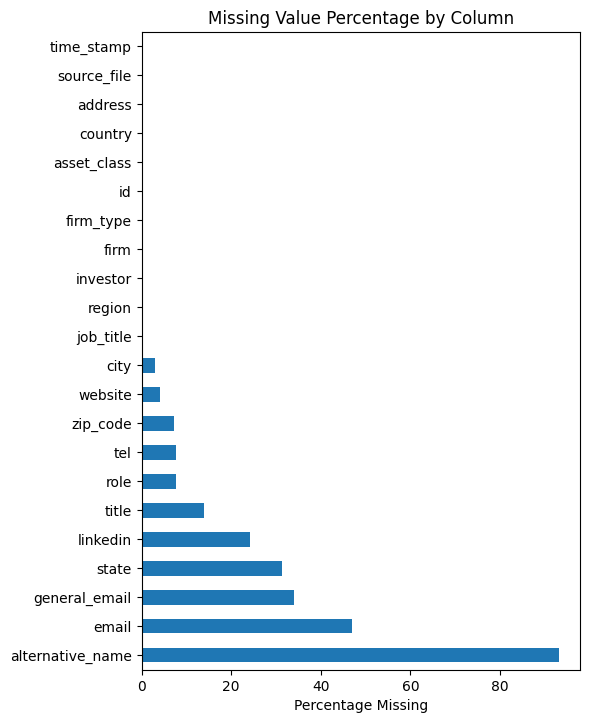

In [7]:
# Find % of missing values per column
missing_pct = lp_df.isna().mean().mul(100).sort_values(ascending=False)

# Quick bar chart to visualise
ax = missing_pct.plot.barh(figsize=(6, max(3, len(missing_pct) / 3)))
plt.title("Missing Value Percentage by Column")
plt.xlabel("Percentage Missing")
plt.tight_layout()

# Export as PNG
plt.savefig("export/plots/missingness_summary_bar_lp.png", dpi=300)

A lot of missing emails. Might have to consider manual recovery.

We'll take a look at the summary statistics next to give us insight into any central tendency or skew.

In [8]:
# Numeric stats: count, mean, etc
stats = lp_df.describe()
stats.to_excel("export/stats/lp_summary_stats_numeric.xlsx")
stats

,id,time_stamp
count,155963.000000,155963
mean,77982.000000,2025-06-20 13:52:05.717770496
min,1.000000,2025-06-20 13:52:05.717771
25%,38991.500000,2025-06-20 13:52:05.717771008
50%,77982.000000,2025-06-20 13:52:05.717771008
75%,116972.500000,2025-06-20 13:52:05.717771008
max,155963.000000,2025-06-20 13:52:05.717771
std,45022.784354,NaN


Only two numeric columns so this is to be expected since ID is auto-incremented and timestamp is the same for all rows.

In [9]:
# Categorical/text: count, unique, etc
stats = lp_df.describe(include="object")
stats.to_excel("export/stats/lp_summary_stats_cat.xlsx")
stats

,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,tel,city,state,country,zip_code,linkedin,region,address,website,general_email,source_file
count,155963,155963,134364,155963,10620,143815,155873,155963,82811,143838,151260,106990,155963,144722,118080,155926,155963,149414,102980,155963
unique,141147,51,18,24133,9771,288,51998,258,79925,57238,4392,528,138,12798,111892,7,22607,20697,14786,1
top,Michael Miller,Wealth Manager,Mr.,Jones Day Defined Benefit Master Trust,Monty Cleworth,Investment Team,Partner,GEN,mmiller@crewcialpartners.com,+1 212 761 4000,New York,NY,US,10022,www.linkedin.com/in/michael-miller-5a060523/,North America,,https://www.jonesday.com/en,contact@weil.com,LP Contact Data
freq,22,47355,101648,1769,10,72284,4873,29617,12,383,12138,14415,95650,1459,13,101374,1848,1769,954,155963


Investor and firm fields have high cardinality, whereas firm type and title do not. As we saw from the bar graphs we have a lot of missing emails. Alternative names are also sparse which is good because it means we can rely more heavily on the stated names.

Lets highlight unique fields specifically to further illustrate the point. 

In [10]:
# Iterate each column and check there unique and highest repeated values.
for col in lp_df.select_dtypes(include="object").columns:
    print(col, "->", lp_df[col].nunique(), "uniques")
    print(lp_df[col].value_counts().head(5))
    print("---")

investor -> 141147 uniques
investor
Michael Miller    22
Michael Smith     17
David Harris      13
David Smith       13
David Lee         13
Name: count, dtype: int64
---
firm_type -> 51 uniques
firm_type
Wealth Manager                 47355
Private Sector Pension Fund    14918
Foundation                     10880
Asset Manager                   8471
Corporate Investor              7916
Name: count, dtype: int64
---
title -> 18 uniques
title
Mr.     101648
Ms       28974
Dr.       1817
Miss       960
Mrs.       713
Name: count, dtype: int64
---
firm -> 24133 uniques
firm
Jones Day Defined Benefit Master Trust            1769
Weil, Gotshal & Manges Pension Fund                954
Retirement Plan for Non Legal Employees of STB     861
Sidley Austin Master Pension Trust                 807
Cerity Partners                                    782
Name: count, dtype: int64
---
alternative_name -> 9771 uniques
alternative_name
Monty Cleworth    10
Jeannie Justie     9
刘伟                 8
李明  

Let's see if there is any corelation for missing columns and rows.

In [11]:
# Compute pairwise missingness
miss_lp = lp_df.isna().astype(int)
corr_lp = miss_lp.corr()

In [12]:
corr_lp["email"].sort_values(ascending=False)

email               1.000000
linkedin            0.143739
tel                 0.125521
website             0.122948
general_email       0.075475
zip_code            0.058902
state               0.028347
city                0.018267
role                0.018178
region              0.005544
job_title          -0.003859
title              -0.064264
alternative_name   -0.166674
id                       NaN
investor                 NaN
firm_type                NaN
firm                     NaN
asset_class              NaN
country                  NaN
address                  NaN
source_file              NaN
time_stamp               NaN
Name: email, dtype: float64

We can see that `general_email`, `linkedin`, `website` have a weak positive correlation with `email `'s missingness, implying that the likelihood of any of them being missing to be connected. Since the correlation is weak, we should have good opportunity to recover missing `email` fields by investigating the associated website or LinkedIn. 

Since the `investor`and `firm` fields are the key signifier of a unique individual (since someone with the same name could work at two different companies) and since have high cardinality we will focus on these. We will omit `email` duplicates since there are so many missing entries. 

In [13]:
# Extract duplicates
dupes_lp = lp_df.duplicated(subset=["investor", "firm"]).sum()
dupes_lp

np.int64(1627)

In [14]:
dup_mask_all = lp_df.duplicated(subset=["investor", "firm"], keep=False)
dupe_rows_all = lp_df[dup_mask_all].sort_values("investor")
dupe_rows_all.head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
71428,84535,A Acuff,Fund of Hedge Funds Manager,Mr.,Silvercrest Asset Management Group,None,"Board of Directors,Investment Team",Managing Director & Member of Investment Polic...,HF,macuff@silvercrestgroup.com,...,NY,US,10019,www.linkedin.com/in/acuff-marshall-46727a140/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-20 13:52:05.717771
140582,15381,A Acuff,Asset Manager,Mr.,Silvercrest Asset Management Group,None,"Board of Directors,Investment Team,Operations,...","Managing Director, Portfolio Manager","PE,RE,HF,PD,NR",macuff@silvercrestgroup.com,...,VA,US,23235,www.linkedin.com/in/acuff-marshall-46727a140/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-20 13:52:05.717771
12733,143230,A Titcomb,Wealth Manager,Mr.,Ipswich Investment Management Company,None,"Investment Team,Legal,Operations","Executive Vice President, Chief Operating Offi...",GEN,ctitcomb@ipswichinvestment.com,...,MA,US,01915,www.linkedin.com/in/cushingtitcomb/,North America,138 Conant Street Suite 201,http://www.ipswichinvestment.com,info@ipswichinvestment.com,LP Contact Data,2025-06-20 13:52:05.717771
12732,143231,A Titcomb,Wealth Manager,Mr.,Ipswich Investment Management Company,None,"Investment Team,Legal,Operations","Executive Vice President, Chief Operating Offi...",GEN,None,...,MA,US,01915,www.linkedin.com/in/cushingtitcomb/,North America,138 Conant Street Suite 201,http://www.ipswichinvestment.com,info@ipswichinvestment.com,LP Contact Data,2025-06-20 13:52:05.717771
145133,10830,Aaron Abrahms,Fund Manager,Mr.,Jasper Ridge Partners,None,Investment Team,Partner,"PE,HF",aabrahms@jasperridge.com,...,CA,US,94025,www.linkedin.com/in/aaronabrahms/,North America,2885 Sand Hill Road Suite 100,http://www.jasperridge.com,investor_relations@jasperridge.com,LP Contact Data,2025-06-20 13:52:05.717771
145132,10831,Aaron Abrahms,Wealth Manager,Mr.,Jasper Ridge Partners,None,Investment Team,Partner,"PE,HF",aabrahms@jasperridge.com,...,CA,US,94025,www.linkedin.com/in/aaronabrahms/,North America,201 Main Street Suite 1000,http://www.jasperridge.com,investor_relations@jasperridge.com,LP Contact Data,2025-06-20 13:52:05.717771
14945,141018,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,"Investment Team,Operations","Co-Founder, Partner & Director of Equity Resea...",GEN,aammerman@alphaky.com,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman-92358323/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-20 13:52:05.717771
14948,141015,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,Investment Team,"Co-Founder, Partner",GEN,None,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-20 13:52:05.717771
95983,59980,Aaron Brodt,Wealth Manager,Mr.,Ashton Thomas Private Wealth,None,Investment Team,Founder and Chief Executive Officer,"PE,HF,PD",None,...,AZ,US,85260,None,North America,8605 East Raintree Drive Suite 280,https://ashtonthomaspw.com/,info@at-pw.com,LP Contact Data,2025-06-20 13:52:05.717771
95994,59969,Aaron Brodt,Wealth Manager,Mr.,Ashton Thomas Private Wealth,None,Investment Team,Founder and Chief Executive Officer,"PE,HF,PD",abrodt@at-pw.com,...,AZ,US,85260,www.linkedin.com/in/aaron-brodt-cima®-96489731/,North America,8605 East Raintree Drive Suite 280,https://ashtonthomaspw.com/,info@at-pw.com,LP Contact Data,2025-06-20 13:52:05.717771


We can infer from the top of the duplicates that alot of them are from the same person but working different roles within the company, likely from internal promotions. It would be interesting to see the fields which are still duplicate in `investor` and `firm` but not in `linkedin`.

In [15]:
# Filter duplicates by unique LinkedIns
link_nunique = dupe_rows_all.groupby(["investor", "firm"])["linkedin"].transform(
    lambda s: s.nunique(dropna=True)
)

# Keep only the rows where there’s more than one distinct LinkedIn
mismatch = dupe_rows_all[link_nunique > 1]

# Filter investor names that only appear once
name_counts = mismatch["investor"].value_counts()
keep_names = name_counts[name_counts > 1].index
final = mismatch[mismatch["investor"].isin(keep_names)]

final.sort_values(["investor", "firm"]).head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
14945,141018,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,"Investment Team,Operations","Co-Founder, Partner & Director of Equity Resea...",GEN,aammerman@alphaky.com,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman-92358323/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-20 13:52:05.717771
14948,141015,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,Investment Team,"Co-Founder, Partner",GEN,None,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-20 13:52:05.717771
128244,27719,Aaron Kowal,Wealth Manager,Mr.,Creative Planning,None,Board of Directors,Partner/Managing Director,"PE,RE,INF,PD",None,...,KS,US,66211,www.linkedin.com/in/aaronkowal /,North America,5454 West 110th Street,https://creativeplanning.com/,cpi@creativeplanning.com,LP Contact Data,2025-06-20 13:52:05.717771
128625,27338,Aaron Kowal,Wealth Manager,Mr.,Creative Planning,None,"Board of Directors,Investment Team","Partner,Managing Director","PE,RE,INF,PD",None,...,FL,US,33904,www.linkedin.com/in/aaronkowal/,North America,5454 West 110th Street,https://creativeplanning.com/,cpi@creativeplanning.com,LP Contact Data,2025-06-20 13:52:05.717771
130952,25011,Aaron Waxman,Wealth Manager,Mr.,Cerity Partners,None,"Finance/Accountancy,Investment Team",Partner,"PE,RE,INF,HF,PD,NR",None,...,CA,US,94104,www.linkedin.com/in/aaron-waxman-cpa-cfp%C2%AE...,North America,99 Park Avenue 16th Floor,https://ceritypartners.com,privacy@ceritypartners.com,LP Contact Data,2025-06-20 13:52:05.717771
50828,105135,Aaron Waxman,Fund of Hedge Funds Manager,Mr.,Cerity Partners,None,Investment Team,Partner,HF,awaxman@ceritypartners.com,...,CA,US,94104,www.linkedin.com/in/aaron-waxman-cpa-cfp®-4aa3...,North America,99 Park Avenue,https://ceritypartners.com/,None,LP Contact Data,2025-06-20 13:52:05.717771
71430,84533,Adam Dahms,Fund of Hedge Funds Manager,Mr.,Silvercrest Asset Management Group,None,Investment Team,Vice President & Senior Equity Analyst,HF,adahms@silvercrestgroup.com,...,WI,US,53202,linkedin.com/in/afdahms,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-20 13:52:05.717771
140596,15367,Adam Dahms,Asset Manager,Mr.,Silvercrest Asset Management Group,None,Investment Team,Senior Equity Analyst,"PE,RE,HF,PD,NR",adahms@silvercrestgroup.com,...,WI,US,53202,www.linkedin.com/in/adam-dahms-37253596/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-20 13:52:05.717771
36232,119731,Alan Merriman,Family Office - Multi,Mr.,Elkstone Partners,None,Investment Team,Chief Executive Officer & Co-Founder,"PE,RE,HF,PD",None,...,None,Ireland,D02 EK81,www.linkedin.com/in/alan-merriman-3a7b643a/?or...,Europe,76 Baggot Street Lower Dublin 2,http://elkstonepartners.com/,info@elkstoneprivate.com,LP Contact Data,2025-06-20 13:52:05.717771
36239,119724,Alan Merriman,Family Office - Multi,Mr.,Elkstone Partners,None,Investment Team,Chief Executive Officer & Co-Founder,"PE,RE,HF,PD",None,...,None,Ireland,D02 EK81,www.linkedin.com/in/alan-merriman-3a7b643a/,Europe,76 Baggot Street Lower Dublin 2,http://elkstonepartners.com/,info@elkstoneprivate.com,LP Contact Data,2025-06-20 13:52:05.717771


This seems like a good way to prove true duplicates, it will come in useful when we begin cleaning. Let's do some email domain analysis to get an idea of what our data looks like.

In [16]:
# Normalise, split into email doamin and group into pairs
df_pairs = (
    lp_df[["firm", "email"]]
    .dropna(subset=["email"])
    .assign(
        domain=lambda d: d["email"].str.split("@").str[-1].str.lower(),
        firm=lambda d: d["firm"].str.lower(),
    )
    .loc[:, ["domain", "firm"]]
)

# Drop duplicates and print
df_unique = df_pairs.drop_duplicates()
df_unique.to_numpy().tolist()

[['albainvestments.ch', 'alba investment partners'],
 ['fondrenoakscapital.com', 'fondren oaks capital management'],
 ['rysecapitalmanagement.com', 'ryse capital management'],
 ['coronadoadvisors.com', 'coronado financial group'],
 ['nicolfinancial.com', 'nicol financial services'],
 ['bluecapitalwealth.com', 'blue capital'],
 ['mcdonnaugh.com', 'ai mcdonnaugh & co.'],
 ['luesinkstenstrom.com', 'luesink stenstrom financial'],
 ['investedgeplanning.com', 'investedge planning'],
 ['myfirmllc.com', 'pursuit wealth management'],
 ['kdmwealth.com', 'kdm wealth management'],
 ['arrowstonewealth.com', 'arrowstone wealth'],
 ['farrautowealth.com', 'farrauto wealth management'],
 ['sunquestwm.com', 'sunquest wealth management'],
 ['berenzwealthmanagement.com', 'berenz wealth management'],
 ['nicholswealthadvisors.com', 'nichols wealth advisors'],
 ['goldmarkfp.com', 'goldmark financial planners'],
 ['celadonwealth.com', 'celadon managed wealth'],
 ['trubeewealth.com', 'trubee wealth advisors'],

They seem to be all firm name domains. To be sure it would be interesting to see which domains are used across different firms. 

In [17]:
# Count how many distinct firms per domain
domain_firm_counts = df_pairs.groupby("domain")["firm"].nunique()


# Only keep domains where span is larger than 1
multi_firm = domain_firm_counts[domain_firm_counts > 1]

print(multi_firm.shape)
multi_firm.sort_values(ascending=False).to_dict()

(1105,)


{'gmail.com': 48,
 'nepc.com': 46,
 'meketa.com': 41,
 'cambridgeassociates.com': 35,
 'marquetteassociates.com': 30,
 'lpl.com': 29,
 'callan.com': 28,
 'andcoconsulting.com': 27,
 'feg.com': 26,
 'mercer.com': 25,
 'segalmarco.com': 24,
 'dahab.com': 23,
 'msgraystone.com': 21,
 'ubs.com': 18,
 'monticelloassociates.com': 17,
 'primebuchholz.com': 16,
 'qq.com': 16,
 'wilshire.com': 14,
 'acgnet.com': 13,
 'crewcialpartners.com': 12,
 'rvkinc.com': 12,
 'verusinvestments.com': 12,
 'meketagroup.com': 11,
 'raymondjames.com': 11,
 'hamiltonlane.com': 11,
 'aonhewitt.com': 11,
 '163.com': 10,
 'stepstoneglobal.com': 10,
 'sphp.com': 9,
 'morganstanley.com': 9,
 'burgesschambers.com': 9,
 'aon.com': 8,
 'samsung.com': 8,
 'cliffwater.com': 8,
 'lcgassociates.com': 8,
 'franklinparkllc.com': 8,
 'wvimb.org': 8,
 'ageas.pt': 8,
 'bmo.com': 8,
 'truist.com': 8,
 'aksia.com': 8,
 'seic.com': 7,
 'wv.gov': 7,
 'macquarie.com': 7,
 'townsendgroup.com': 7,
 'albourne.com': 7,
 'winvcounsel.com

So clearly gmail is generic email domain, probably an individual investor. Whereas other domains seem to be associated with either subtly misspelled firm names or different departments within the same firm.

The next thing to look at is string length distributions to see if we can identify any obvious outliers.

In [18]:
# Compute lengths for each column
length_df = pd.DataFrame(
    {
        "investor_len": lp_df["investor"].dropna().str.len(),
        "email_len": lp_df["email"].dropna().str.len(),
        "firm_len": lp_df["firm"].dropna().str.len(),
    }
)

# Show summary stats
length_df.describe().T

,count,mean,std,min,25%,50%,75%,max
investor_len,155963.0,13.125331,2.944069,3.0,11.0,13.0,15.0,57.0
email_len,82811.0,24.078178,5.456499,8.0,20.0,24.0,28.0,62.0
firm_len,155963.0,24.162481,11.653290,2.0,16.0,23.0,30.0,100.0


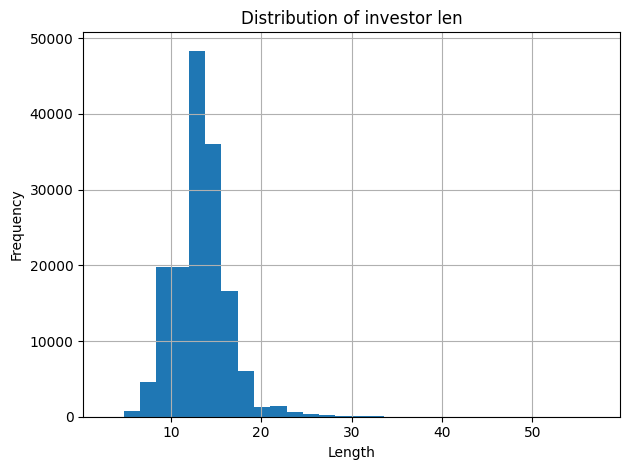

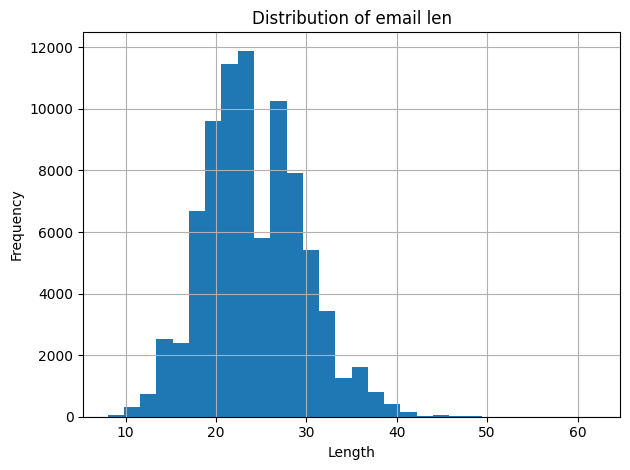

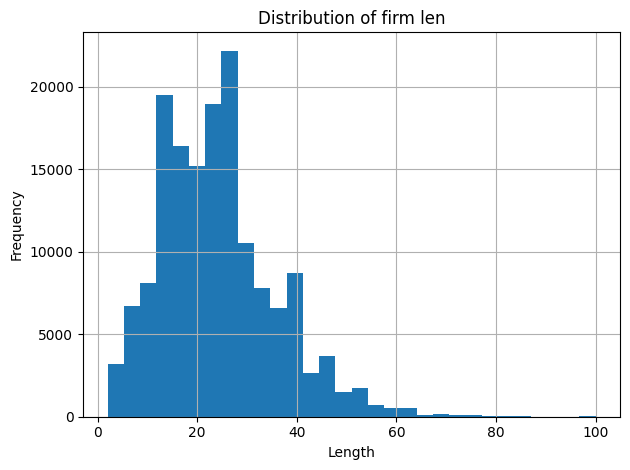

In [19]:
# Plot each distribution
for col in ["investor_len", "email_len", "firm_len"]:
    plt.figure()
    length_df[col].hist(bins=30)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    # Save figure
    out_path = f"export/plots/{col}_hist_lp.png"
    plt.savefig(out_path, dpi=300)
    plt.show()

From the plots and tables, we can see that almost every investor name is between 8-18 characters, with a few extremely short and long names. We something similar but with different ranges for email and firm names.

This will inform the ranges we will use to flag anomalies for manual review.

# Initial Data Cleaning

Now that data cleaning functions have been defined, it is time to do some more EDA to see where we are at before we move onto imputation. We should focus on which fields are missing and which are recoverable. Ultimately the ML model will take investor name and firm name pairs as inputs, so other fields may not be important. However, our initial EDA discovered a lot of missing emails. Our data cleaning process will flag definite duplicates and ambiguous cases for manual review. We'll start by cleaning.

In [20]:
transformed_data_lp = transform_table(TableName.LP)
clean_lp = transformed_data_lp["final_df"]

Read LP table from database!
Table Normalisation Complete!
Table Regex-Cleaning Complete!
Removed 18 bad investor rows!
Table Standardisation Complete!
79 invalid emails lengths found!
73142 missing emails!
31 invalid emails found!
396 invalid LinkedIns found!
37879 missing LinkedIns!
2128 invalid firm lengths found!
0 missing firms!
8521 invalid investor lengths found!
0 missing investors!
22564 missing linkedin and email pairs!
Found 6642 duplicates (excluding retained best row per investor group).
Found 14080 ambiguous duplicates!


Ok, as we already knew, we have a lot of missing emails, with a only a few invalid and potentially invalid emails. We have also identified a decent amount of duplicates and a few ambiguous duplicates for manual inspection.

In [21]:
df = transformed_data_lp["deduplication"]["definite_duplicates"]

# Sort by investor name and email for easier inspection
df_sorted = df.sort_values(by=["investor", "email", "linkedin"])

# View the top rows
print(df_sorted[["id", "investor", "email", "linkedin", "firm", "role"]].head(50))

            id             investor                            email  \
140582   15381              a acuff      macuff@silvercrestgroup.com   
95980    59983           a j shurts                             None   
12732   143231            a titcomb                             None   
145133   10830        aaron abrahms         aabrahms@jasperridge.com   
96007    59956     aaron abramovitz     aabramovitz@georgiapower.com   
131789   24174      aaron alexander                             None   
152597    3366         aaron copple                             None   
44942   111021          aaron hagar                             None   
84941    71022          aaron lally                alally@meketa.com   
122257   33706          aaron maxey                             None   
9365    146598       aaron meissner                             None   
115571   40392         aaron neuman                             None   
3434    152529         aaron pierce                             

This looks good, solid duplicates found and dealt with. Lets take a look at the ambiguous cases to see if there are any trends to be found.

In [22]:
ambiguous_duplicates_df = transformed_data_lp["deduplication"]["ambiguous_duplicates"]

# Sort by investor name and email for easier inspection
ambiguous_duplicates_df = ambiguous_duplicates_df.sort_values(
    by=["investor", "email", "linkedin"]
)

# Select relevant columns and top 50 rows
top50 = ambiguous_duplicates_df[
    ["id", "investor", "email", "linkedin", "firm", "role"]
].head(50)

# Save to Excel
top50.to_excel("export/stats/ambiguous_duplicates_top50_lp.xlsx", index=False)

print(ambiguous_duplicates_df.shape)
top50

(14080, 22)


,id,investor,email,linkedin,firm,role
14945,141018,aaron ammerman,aammerman@alphaky.com,www.linkedin.com/in/aaron-ammerman-92358323/,alpha financial partners,"investment team,operations"
14948,141015,aaron ammerman,None,www.linkedin.com/in/aaron-ammerman/,alpha financial partners,investment team
95994,59969,aaron brodt,abrodt@at-pw.com,www.linkedin.com/in/aaron-brodt-cima®-96489731/,ashton thomas private wealth,investment team
6526,149437,aaron brodt,None,linkedin.com/in/aaron-brodt-cima,amplify financial,investment team
95983,59980,aaron brodt,None,None,ashton thomas private wealth,investment team
123872,32091,aaron cohen,None,www.linkedin.com/in/aaron-cohen-0a75821/,gyl financial synergies,"board of directors,investment team"
25496,130467,aaron cohen,None,www.linkedin.com/in/aaron-cohen-8aa12a232/,city national bank investment management,finance/accountancy
89178,66785,aaron foster,aaron.foster@compoundplanning.com,www.linkedin.com/in/aaroncfoster/,compound planning,investment team
38522,117441,aaron foster,None,None,rbc dominion securities,investment team
18027,137936,aaron jones,amjones@ft.newyorklife.com,www.linkedin.com/in/aaronjones1/,eagle strategies,investment team


From a quick precursory look, we can see there are a few cases where people with the same name have different email domains. Possibly the same person in a different position or two different people with the same name. There are also a few cases of the same name but one instance with a missing email, once again could be the same person or two different people with the same name. Lets look at some more statistics. 

In [23]:
# How many investors have >2 entries
ambiguous_counts = ambiguous_duplicates_df["investor"].value_counts()
print(ambiguous_counts.describe())
print(ambiguous_counts[ambiguous_counts > 2].head(10))

count    5929.000000
mean        2.374768
std         0.975170
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        14.000000
Name: count, dtype: float64
investor
michael smith    14
david harris     13
john williams    12
wei zhang        12
michael lee      12
mark smith       11
david brown      11
david smith      11
robert smith     11
mark johnson     11
Name: count, dtype: int64


High frequency names are probably false positives. There are also a lot of ambiguous investor duplicates with most of them occurring twice. Only a handful go up to 10+ entries, these should be the priority for manual inspection.

In [24]:
# View all entries for a specific investor (e.g. top ambiguous case)
investor = ambiguous_counts.idxmax()
print(
    ambiguous_duplicates_df[ambiguous_duplicates_df["investor"] == investor][
        ["id", "email", "linkedin", "firm", "role"]
    ]
)

            id                           email  \
83175    72788      masmith@illinoismutual.com   
73117    82846   michael.smith@newcastlede.gov   
26399   129564  michaelsmith@avidianwealth.com   
86897    69066                 msmith@ehcp.com   
18740   137223           msmith@emeraldadv.com   
43112   112851             msmith@local810.org   
9604    146359             msmith@profocus.com   
25016   130947          msmith@trtholdings.com   
155401     562              smith@aresmgmt.com   
21754   134209                            None   
95263    60700                            None   
12056   143907                            None   
65609    90354                            None   
122143   33820                            None   

                                                 linkedin  \
83175                                                None   
73117         www.linkedin.com/in/michael-smith-80527896/   
26399         www.linkedin.com/in/michael-smith-49898412/   
86897

Here is an example of a false positive. Micheal Smith is clearly a common name in the investor space and we will need to do manual inspection on the high occurring duplicates to sift the duplicates from the true values.

Let's take a look at our missing values to see if we can better inform our imputation strategy. 

In [25]:
# Check null percentage per column
missing_summary = clean_lp.isnull().mean().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

alternative_name    0.937133
email               0.461238
general_email       0.333375
state               0.322970
linkedin            0.241024
title               0.147645
role                0.080193
tel                 0.077161
zip_code            0.071985
website             0.040496
city                0.029921
job_title           0.000547
region              0.000170
dtype: float64


Fields like `state`, `city`, `zip_code`, `region`, `title` and `role` could be useful for filtering duplicates and have relatively low missing rates. These fields could reasonably inferred from the firm name. 

The priority here is clearly the `email` is the priority, potentially we could fallback to general email or even the LinkedIn profile. Lets see how often `email`, `linkedin` and `general_email` are missing together.

In [26]:
# Check email and general email missingness
email_missing_general_present = (
    clean_lp["email"].isnull() & clean_lp["general_email"].notnull()
)
email_present_general_missing = (
    clean_lp["email"].notnull() & clean_lp["general_email"].isnull()
)
both_missing = clean_lp["email"].isnull() & clean_lp["general_email"].isnull()

# Check email and linkedin missingness
email_missing_linkedin_present = (
    clean_lp["email"].isnull() & clean_lp["linkedin"].notnull()
)
email_present_linkedin_missing = (
    clean_lp["email"].notnull() & clean_lp["linkedin"].isnull()
)
both_missing_linkedin = clean_lp["email"].isnull() & clean_lp["linkedin"].isnull()

# Print summary counts
print("Email missing & General Email present:", email_missing_general_present.sum())
print("Email present & General Email missing:", email_present_general_missing.sum())
print("Both Email and General Email missing:", both_missing.sum())
print("Email missing & LinkedIn present:", email_missing_linkedin_present.sum())
print("Email present & LinkedIn missing:", email_present_linkedin_missing.sum())
print("Both Email and LinkedIn missing:", both_missing_linkedin.sum())

Email missing & General Email present: 39069
Email present & General Email missing: 21779
Both Email and General Email missing: 23301
Email missing & LinkedIn present: 43352
Email present & LinkedIn missing: 13574
Both Email and LinkedIn missing: 19018


So clearly there is oppurtunity to recover missing emails from LinkedIn and maybe even general email. Although using the general email as fallback could pollute the dataset as we miss out on the syntactic structure of first and last name in the email construction.

Lets see if there is any corelation between the missing values.

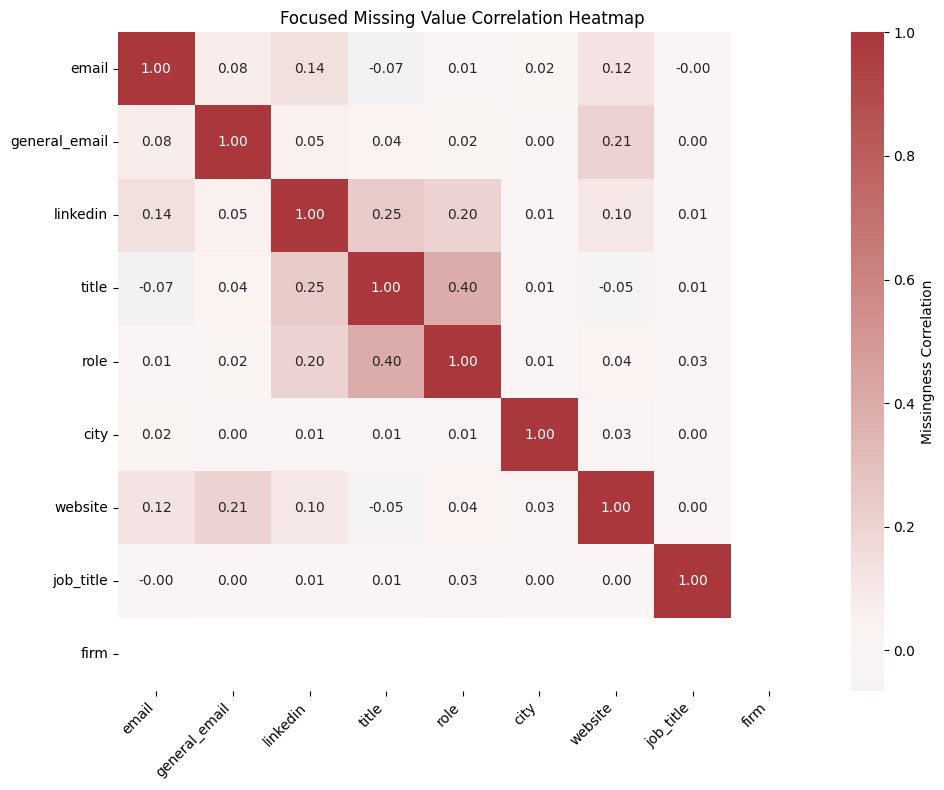

In [27]:
# Correlation between relevant fields
fields = [
    "email",
    "general_email",
    "linkedin",
    "title",
    "role",
    "city",
    "website",
    "job_title",
    "firm",
]

# Filter and create massiness matrix
missing_corr = clean_lp[fields].isnull().astype(int).corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_corr,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    cbar_kws={"label": "Missingness Correlation"},
)
plt.title("Focused Missing Value Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save
plt.savefig("export/plots/missingness_correlation_heatmap_lp.png", dpi=300)

Clearly missingingness is unrelated. Not very useful for imputation strategy, seems the plan is to manually inspect high occurring ambiguous duplicates. Then drop fields with missing `email`s and consider recovery for the remaining missing fields once pattern mining is done. That way, if certain templates appear to be consistently associated with a certain domain, we can programmatically recover missing emails for those firms/domains.

In [28]:
clean_lp = drop_rows_missing_emails(clean_lp)
clean_lp.shape

(72853, 22)

First thing to do is look at our flagged invalid emails. Theres only a few so we can take a look here.

In [29]:
invalid_ids = transformed_data_lp["validation"]["invalid_email"]
# Pull those rows from the main clean dataset
invalid_emails_df = clean_lp[clean_lp["id"].isin(invalid_ids)].copy()

display(
    HTML(
        invalid_emails_df[["investor", "email"]]
        .to_html()
        .replace("<table", '<div style="max-height:300px;overflow:auto;"><table')
        .replace("</table>", "</table></div>")
    )
)

,investor,email
1642,phillip hulme,phillip.hulme@starsandstripesfinancialadvisors.com
5245,christoph portmann,christoph.portmann@lakeshore-international.com
5246,corinne bachmann,corinne.bachmann@lakeshore-international.swiss
6968,jérôme lefèvre,j.lefèvre@groupe-baelen.fr
7209,jon popielarski,jonathan.popielarski@ballastequitypartners.com
7739,thomas doering,thomas.döring@liquidpartners.de
12807,madeline hedges,madeline.hedges@dinsmorecomplianceservices.com
18671,alexandre chasseriaud,alexandre.chasseriaud@banquetransatlantique.com
20137,carolanne chavanne,carolannechavanne@prosperitywealthplanning.com
20777,kevin coscarelli,kevin.coscarelli@westchesterfinancialpartners.com


These largely are flagged for being outside the expected character range. They do not appear to be invalid except for `ami zeig` who has a 'æ' in their email. Strange unicodes are generally not accepted in most legacy (especially B2B systems) but generally are accepted for international email. Will introduce another cleaning function that drops incongruent unicodes that do not appear in the investor's name. We will do the same for other non a-z characters, like '?'.

In [30]:
print(clean_lp.shape)
clean_lp = drop_emails_with_unmatched_nonalpha(clean_lp)
print(clean_lp.shape)

(72853, 22)
(72846, 22)


Lets take a look at our ambiguous duplicates. Theres a lot of them so lets try to group them to filter into smaller groups. We'll try same name and role, and same name and firm.

In [31]:
# Clean records
ambiguous_duplicates_df = drop_rows_missing_emails(ambiguous_duplicates_df)
ambiguous_duplicates_df = drop_emails_with_unmatched_nonalpha(ambiguous_duplicates_df)

# Group by role
grouped_role = ambiguous_duplicates_df.groupby(["investor", "role"])
group_sizes = (
    grouped_role.size().reset_index(name="count").sort_values("count", ascending=False)
)
display(group_sizes.head())

,investor,role,count
1227,david harris,investment team,7
3861,michael smith,investment team,6
3746,michael lee,investment team,6
599,brian johnson,investment team,6
2678,john williams,investment team,5


Ok these are likely have some duplicates within them. Lets see what the diversity of firms are in the group.

In [32]:
firm_diversity = (
    grouped_role["firm"]
    .nunique()
    .reset_index(name="unique_firms")
    .sort_values("unique_firms", ascending=False)
)

# How many are spread across multiple firms?
num_multi_firm = (firm_diversity["unique_firms"] > 1).sum()
print(f"{num_multi_firm} of {firm_diversity.shape[0]} groups span multiple firms")

555 of 5504 groups span multiple firms


Seems like we could be looking at the same person duplicated at different companies during different points of there career. Lets see the stats for unique firm per group.

In [33]:
group_stats = group_sizes.merge(firm_diversity, on=["investor", "role"])
top_20_carreer_move = group_stats.sort_values("unique_firms", ascending=False).head(20)

# Export top 20 rows sorted by unique firm count
top_20_carreer_move.to_excel(
    "export/stats/career_move_stats_top20_lp.xlsx", index=False
)

display(top_20_carreer_move)

,investor,role,count,unique_firms
0,david harris,investment team,7,7
1,michael smith,investment team,6,6
2,michael lee,investment team,6,6
3,brian johnson,investment team,6,6
4,john williams,investment team,5,5
15,brian kim,investment team,4,4
14,john lee,investment team,4,4
13,john kim,investment team,4,4
11,michael bradley,investment team,4,4
10,mike chen,investment team,4,4


So clearly there is a few instances during at the top of the group frame that may be false positives. Or at least include false positives. It also seems that the unique firm distribution has a long tail, let's throw `job_title` into the mix to see if that refines our ambiguous duplicate space.

In [34]:
grouped_role_job = ambiguous_duplicates_df.groupby(["investor", "role", "job_title"])
group_sizes = (
    grouped_role_job.size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
display(group_sizes.head())
group_sizes.shape

,investor,role,job_title,count
3873,matthew lugar,investment team,managing director,2
3673,mark mitchell,finance/accountancy,chief financial officer,2
3176,julie sullivan,investment team,president,2
3244,katherine nugent,investment team,associate,2
4108,michael jackson,investment team,venture partner,2


(6105, 4)

Ok this refines things. Lets take a look at the job spread.

In [35]:
firm_spread = grouped_role_job["firm"].nunique().reset_index(name="unique_firms")
group_stats = group_sizes.merge(firm_spread, on=["investor", "role", "job_title"])
# Get Row Ids
group_ids = grouped_role_job["id"].apply(list).reset_index(name="ids")
# Merge for traceability
group_stats = group_stats.merge(group_ids, on=["investor", "role", "job_title"])
display(group_stats.head())

,investor,role,job_title,count,unique_firms,ids
0,matthew lugar,investment team,managing director,2,2,"[82204, 2686]"
1,mark mitchell,finance/accountancy,chief financial officer,2,2,"[117486, 112664]"
2,julie sullivan,investment team,president,2,2,"[68312, 132390]"
3,katherine nugent,investment team,associate,2,1,"[77054, 77345]"
4,michael jackson,investment team,venture partner,2,2,"[67003, 125336]"


The matching count and unique firm count strongly indicate duplicates of people that have left a company to somewhere new. I am now rethinking manual deduplication, instead this grouping provides valuable data for our model. Since our data works of `investor`-`firm` pairs, the same person across different companies is valuable training data. We will include this grouping and merge it into our clean database.

In [36]:
# Find career moves in ambiguous set
career_moves = group_stats[group_stats["count"] == group_stats["unique_firms"]]
# Get the IDs for those groups
career_move_ids = career_moves["ids"].explode().astype(int)
# Pull the matching rows from ambiguous_duplicates_df
career_move_rows = ambiguous_duplicates_df[
    ambiguous_duplicates_df["id"].isin(career_move_ids)
]
print("Career move count now:", len(career_move_ids))
# Merge these into clean_lp (stack them together)
clean_lp_extended = pd.concat([clean_lp, career_move_rows], ignore_index=True)
clean_lp.shape, clean_lp_extended.shape

Career move count now: 6141


((72846, 22), (78987, 22))

This looks like our final clean LP dataset. Time to write it back to the database.

In [37]:
load_clean_data(TableName.LP_CLEAN, clean_lp_extended)

78987 upserted, 0 inserted into LP_CLEAN
Wrote 78987 rows to LP_CLEAN
78987 upserted, 0 inserted into COMBINED_CLEAN
Also wrote 78987 rows to COMBINED_CLEAN


# Post Cleaning EDA
Below we will conduct our final round of EDA on the cleaned data. We will do some Firm-to-Domain analysis which should give valuable context to our template distribution analysis we will do in the next phase. We'll also look into key field cardinality and some basic domain analysis.

Lets start with plotting firm and domain counts.

Read LP_CLEAN table from database!
(934,)


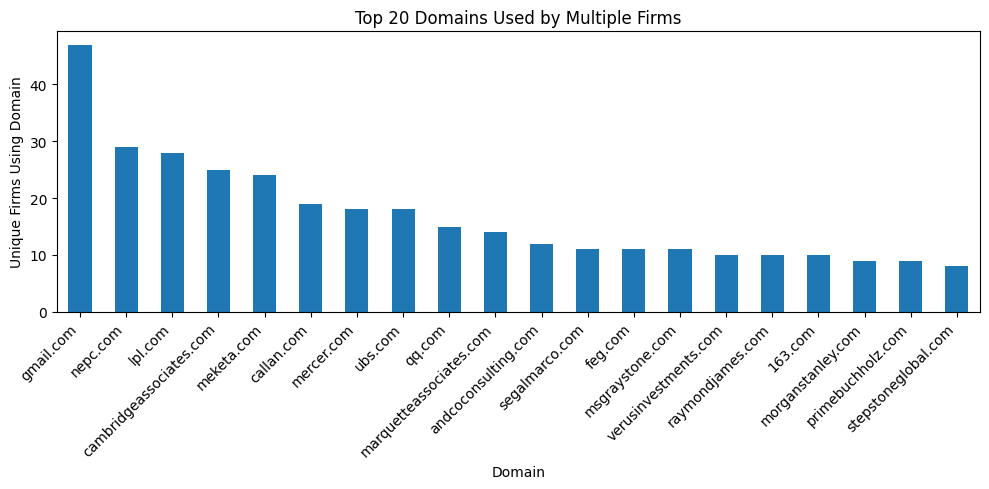

In [38]:
# Load the clean LP data
lp_df = read_table(TableName.LP_CLEAN)
# Extract domain and count firms per domain
lp_df["domain"] = lp_df["email"].str.extract("@(.*)$")[0].str.lower()
domain_firm_counts = (
    lp_df.groupby("domain")["firm"].nunique().sort_values(ascending=False)
)

# Filter to only domains used by >1 firm (for clarity)
shared_domains = domain_firm_counts[domain_firm_counts > 1]
print(shared_domains.shape)

plt.figure(figsize=(10, 5))
shared_domains.head(20).plot(kind="bar")
plt.title("Top 20 Domains Used by Multiple Firms")
plt.xlabel("Domain")
plt.ylabel("Unique Firms Using Domain")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the figure
plt.savefig("export/plots/top_20_shared_domains_lp.png", dpi=300)

plt.show()

So clearly "gmail.com" is generic email probably used by an individual investor. But other cases of domains used by 10-30 firms are a bit more ambiguous - could be holding companies or multi brand orgs, or it could be misattributed firms names.

Let's look at a specific example.

In [39]:
lp_df[lp_df["domain"] == "lpl.com"][["investor", "firm", "email", "website"]].head(20)

,investor,firm,email,website
74,katie mcdonald,van leeuwen retirement & investment services,katie.mcdonald@lpl.com,www.vlretirement.com
75,kristoffer arnold,van leeuwen retirement & investment services,kristoffer.arnold@lpl.com,www.vlretirement.com
76,mark vanleeuwen,van leeuwen retirement & investment services,mark.vanleeuwen@lpl.com,www.vlretirement.com
779,michael custer,harborfront financial group,michael.custer@lpl.com,www.harborfrontfinancial.com/
780,elizabeth kuiper,harborfront financial group,elizabeth.dekuiper@lpl.com,www.harborfrontfinancial.com/
3421,cara flynt,red mountain financial partners,cara.flynt@lpl.com,redmountainfinancialpartners.com
3422,michael warren,red mountain financial partners,michael.warren@lpl.com,redmountainfinancialpartners.com
5629,sean rooney,prospect financial services,sean.rooney@lpl.com,www.profinserv.net/
7295,ben jones,wiregrass asset management,ben.jones@lpl.com,www.wiregrassinvest.com
7426,scott barsness,five talents financial management group,s.barsness@lpl.com,www.ftfmg.com


So it seems like despite the shared domains coming from different firms, they generally follow the same template structure. However, it represents a potential edge case where they don't. In such a case, providing a domain name to the predictor could be unreliable or even pollute the dataset, since the domain could be used by multiple firms each using different email templates. This could lead to overgeneralization in some cases.

To combat this I think adding a boolean `shared_domain` flag to the clean data could help us disambiguate by giving more weight to the `firm` name when the flag is true and lowering confidence thresholds such that we more aggressively rely on fallbacks. We could even use a secondary classifier if the model is still unsure.

In [40]:
lp_df["is_shared_infra"] = lp_df["domain"].isin(shared_domains.index)

Lets do the same for domains per firm.

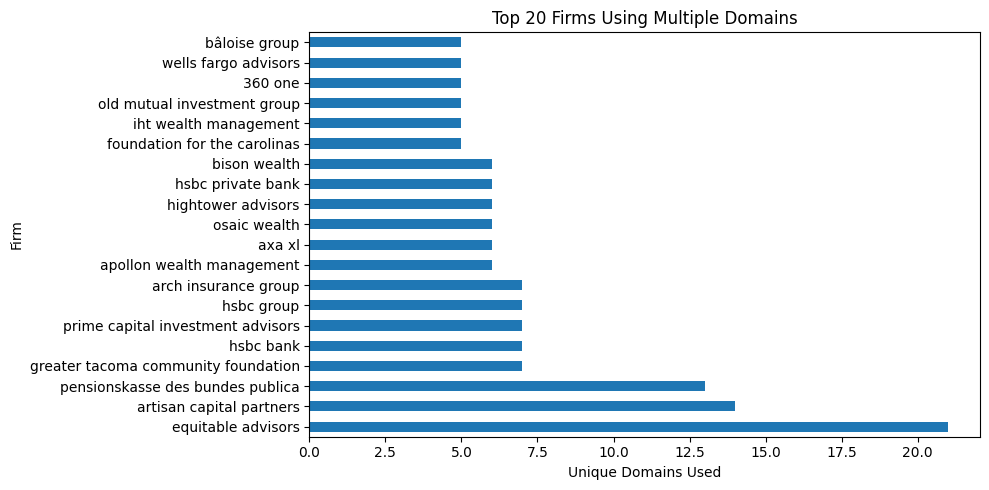

In [41]:
# Count domains per firm
firm_domain_counts = (
    lp_df.groupby("firm")["domain"].nunique().sort_values(ascending=False)
)

# Filter to firms using >1 domain
multi_domain_firms = firm_domain_counts[firm_domain_counts > 1]

plt.figure(figsize=(10, 5))
multi_domain_firms.head(20).plot(kind="barh")
plt.title("Top 20 Firms Using Multiple Domains")
plt.xlabel("Unique Domains Used")
plt.ylabel("Firm")
plt.tight_layout()

# Save the figure
plt.savefig("export/plots/top_20_shared_firms_lp.png", dpi=300)

plt.show()

The chart shows a complementary story, where multiple domains are used with the same firm. This could be from subsidiaries or regional branches, let's look at a specific case.

In [42]:
# Subset for firm
df = lp_df[lp_df["firm"].str.lower() == "equitable advisors"].copy()
# Extract domain
df["domain"] = df["email"].str.extract(r"@(.+)$")[0].str.lower()
# Drop duplicates based on domain
unique_domains_df = df.drop_duplicates(subset="domain")

unique_domains_df[["investor", "firm", "email", "website"]].head(20)

,investor,firm,email,website
62684,linda banks,equitable advisors,linda.banks@equitable.com,www.empirestate.equitableadvisors.com/
62691,kevin cook,equitable advisors,kevin.cook@phoenixprivatewealth.com,www.empirestate.equitableadvisors.com/
62696,ryan mickendrow,equitable advisors,rmickendrow@tpsfinancial.com,www.empirestate.equitableadvisors.com/
62710,kristopher taubald,equitable advisors,ktaubald@thefalconfinancialgroup.com,www.empirestate.equitableadvisors.com/
62713,josie streicher,equitable advisors,jellison@voyageurfinancialgroup.com,www.empirestate.equitableadvisors.com/
62716,tyler berg,equitable advisors,tyler.berg@equitable.om,www.empirestate.equitableadvisors.com/
62722,adam kroll,equitable advisors,akroll@highlandfinancialgroup.com,www.empirestate.equitableadvisors.com/
62724,kevin dachille,equitable advisors,kevin.dachille@equitable.conm,www.empirestate.equitableadvisors.com/
62734,michael divito,equitable advisors,michael.divito@equtiable.com,www.empirestate.equitableadvisors.com/
62740,sean burke,equitable advisors,sean@southwestwealthstrategies.com,www.empirestate.equitableadvisors.com/


Using the same logic in the reverse case, we should incorporate a similar flag to inform our model of these cases.

In [43]:
lp_df["firm_is_multi_domain"] = lp_df["firm"].isin(multi_domain_firms.index)

Lets inspect our `firm` and `domain` cardinality. 

In [44]:
print("Unique firms:", lp_df["firm"].nunique())
print("Unique domains:", lp_df["domain"].nunique())
print("Top domains:\n", lp_df["domain"].value_counts().head(10))
print("Top firms:\n", lp_df["firm"].value_counts().head(10))

Unique firms: 15125
Unique domains: 15637
Top domains:
 domain
jonesday.com          1713
weil.com               938
stblaw.com             854
sidley.com             799
whitecase.com          748
akingump.com           557
ropesgray.com          555
merceradvisors.com     335
psc.com                319
aresmgmt.com           283
Name: count, dtype: int64
Top firms:
 firm
jones day defined benefit master trust                  1713
weil, gotshal & manges pension fund                      938
retirement plan for non legal employees of stb           853
sidley austin master pension trust                       800
white & case llp master retirement trust                 748
ropes & gray llp supplemental retirement shares plan     556
akin gump strauss hauer & feld llp master trust          556
mercer global advisors                                   335
piper sandler                                            324
ares management                                          285
Name: count, d

So it seems like we have pretty consistent domain-firm mapping for most cases, this means our secondary pattern miner (trained on domain-firm templates) should successfully capture the majority of cases. It also seems like most firms use one domain which should indicate a dwindling effect by the edge cases.

It would be interesting to see how consistent each domain is in terms of email local-part structure.

In [45]:
# Extract domain and local-part
lp_df["local_part"] = lp_df["email"].str.extract(r"^([^@]+)")[0]

# Compute entropy per domain
domain_entropy = (
    lp_df.dropna(subset=["local_part", "domain"])
    .groupby("domain")["local_part"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .sort_values(ascending=False)
)

# See how consistent top domains are
domain_entropy.loc[
    ["jonesday.com", "weil.com", "stblaw.com", "sidley.com", "whitecase.com"]
]

domain
jonesday.com     7.446001
weil.com         6.843750
stblaw.com       6.749931
sidley.com       6.683361
whitecase.com    6.617403
Name: local_part, dtype: float64

So we have some pretty diverse domains. Probably due to the size of the companies but would be interesting to see how they look in terms of distribution of template structure. But all in good time, I will write some migration files to write the new flags back into the database. After that I will do a quick run through for both the GP and combined datasets. 

In [46]:
# Migrate to new schema
run_all_migrations()
# Drop superfluous columns
lp_df.drop(columns=["local_part", "domain"], inplace=True)

# Write back to table
load_clean_data(TableName.LP_CLEAN, lp_df)

Column 'is_shared_infra' already exists in 'lp_clean'.
Column 'firm_is_multi_domain' already exists in 'lp_clean'.
Column 'is_shared_infra' already exists in 'gp_clean'.
Column 'firm_is_multi_domain' already exists in 'gp_clean'.
Column 'is_shared_infra' already exists in 'combined_clean'.
Column 'firm_is_multi_domain' already exists in 'combined_clean'.
78987 upserted, 0 inserted into LP_CLEAN
Wrote 78987 rows to LP_CLEAN
78987 upserted, 0 inserted into COMBINED_CLEAN
Also wrote 78987 rows to COMBINED_CLEAN


### Cleaning Decisions Summary
- Dropped rows missing email or with structurally invalid emails
- Merged ambiguous duplicates with `count == unique_firms` as valid career moves
- Added `is_shared_infra` and `firm_is_multi_domain` for template disambiguation